# Road Accidents & Pollution Analysis - Data Mart

In [8]:
# --- SETUP ---
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import os
import geodatasets

## Load Data

In [2]:
# --- 1. LOAD OPTIMIZED DATA ---
# Load only relevant columns to reduce memory usage
accidents = pd.read_csv("./datasets/US_Accidents.csv", index_col=[0])

accidents_origin = accidents.copy()


pollution = pd.read_csv("./datasets/US_Pollution.csv", index_col=[0])

pollution_origin = pollution.copy()

In [ ]:
accidents = accidents_origin.copy()
pollution = pollution_origin.copy()

## ENTITY RESOLUTION & DATA FUSION

In [10]:
# --- 2. INITIAL PREPROCESSING ---
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'], format='mixed', errors='coerce')
accidents = accidents.dropna(subset=['Start_Time'])

accidents['Date'] = accidents['Start_Time'].dt.date
pollution['Date'] = pd.to_datetime(pollution['Date']).dt.date

# Remove espaços em branco extras (início/fim e múltiplos espaços internos)
accidents['City'] = accidents['City'].str.strip()             # remove espaços no início e no fim
accidents['City'] = accidents['City'].str.replace(r'\s+', ' ', regex=True)  # reduz múltiplos espaços internos a 1 espaço
# Remove espaços em branco extras (início/fim e múltiplos espaços internos)
pollution['City'] = pollution['City'].str.strip()             # remove espaços no início e no fim
pollution['City'] = pollution['City'].str.replace(r'\s+', ' ', regex=True)  # reduz múltiplos espaços internos a 1 espaço

accidents['City'] = accidents['City'].str.title()
pollution['City'] = pollution['City'].str.title()
pollution = pollution[(pollution['Date'] >= min(accidents['Date'])) & (pollution['Date'] <= max(accidents['Date']))]

In [11]:
# --- 3. ENTITY RESOLUTION ---
def resolve_city_names(pollution_cities, accident_cities):
    resolved = {}
    for city in pollution_cities:
        match, score = process.extractOne(city, accident_cities)
        resolved[city] = match if score >= 90 else None
    return resolved

pollution_cities = pollution['City'].dropna().unique()
accident_cities = accidents['City'].dropna().unique()
city_map = resolve_city_names(pollution_cities, accident_cities)
pollution['City_Resolved'] = pollution['City'].map(city_map)
pollution = pollution.dropna(subset=['City_Resolved'])

In [12]:
print("Colunas após ajustes:", pollution.columns.tolist()) 
if 'City_Resolved' in pollution.columns:
    pollution_resolve = pollution.copy()
    print("criou City_Resolved")

Colunas após ajustes: ['Date', 'Address', 'State', 'County', 'City', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'City_Resolved']
criou City_Resolved


In [16]:
pollution = pollution_resolve.copy()

In [17]:
# --- 4. DATA FUSION ---

# Remove a coluna 'City' se existir
if 'City' in pollution.columns:
    pollution = pollution.drop(columns=['City'])

# Renomeia 'City_Resolved' para 'City' se existir
if 'City_Resolved' in pollution.columns:
    pollution = pollution.rename(columns={'City_Resolved': 'City'})

merged = pd.merge(accidents, pollution, on=['Date', 'City'], suffixes=("_acc", "_pol"), how='inner')

merged.head()

# Estratégia de slot filling + conflict resolution
def fuse_city(row):
    acc = row["City_acc"]
    pol = row["City_pol"]
    if pd.isna(acc) and pd.notna(pol):
        return pol
    elif pd.notna(acc) and pd.notna(pol):
        if acc.strip().lower() == pol.strip().lower():
            return acc
        else:
            return acc  # preferência para accidents
    return acc if pd.notna(acc) else pol

def fuse_state(row):
    acc = row["State_acc"]
    pol = row["State_pol"]
    if pd.isna(pol) and pd.notna(acc):
        return acc
    elif pd.notna(pol) and pd.notna(acc):
        if acc.strip().lower() == pol.strip().lower():
            return pol
        else:
            return pol  # preferência para pollution
    return pol if pd.notna(pol) else acc

# Aplicar funções de fusão
#merged["City"] = merged.apply(fuse_city, axis=1) Apenas exemplo
merged["State"] = merged.apply(fuse_state, axis=1)


merged = merged.drop(columns=["State_acc", "State_pol"])
accidents_pollution = merged.copy()

# Visualizar
accidents_pollution.head()

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,State
0,Source2,2,2016-02-08 12:41:08,2016-02-08 13:11:08,40.158024,-82.641762,NaN,NaN,1.32,Accident on County Hwy-16 Sportsman Club Rd be...,...,7.0,2.791667,5.0,9,7.0,11.833333,24.0,1,23,Pennsylvania
1,Source2,3,2016-02-11 05:32:29,2016-02-11 06:02:29,41.422199,-81.843018,NaN,NaN,0.01,Accident on I-480 Westbound at Exit 9 OH-17 Br...,...,3.0,11.652174,32.0,14,46.0,6.260870,11.0,19,10,Ohio
2,Source2,3,2016-02-11 05:32:29,2016-02-11 06:02:29,41.422199,-81.843018,NaN,NaN,0.01,Accident on I-480 Westbound at Exit 9 OH-17 Br...,...,3.0,11.382609,31.2,14,44.0,6.260870,11.0,19,10,Ohio
3,Source2,3,2016-02-11 06:29:00,2016-02-11 21:00:00,41.420818,-81.694008,NaN,NaN,0.01,Accident on I-480 Eastbound at Exit 16 OH-94 S...,...,3.0,11.652174,32.0,14,46.0,6.260870,11.0,19,10,Ohio
4,Source2,3,2016-02-11 06:29:00,2016-02-11 21:00:00,41.420818,-81.694008,NaN,NaN,0.01,Accident on I-480 Eastbound at Exit 16 OH-94 S...,...,3.0,11.382609,31.2,14,44.0,6.260870,11.0,19,10,Ohio


In [15]:
accidents_pollution.to_csv("Weather-Road.csv", index=False)

## Import Data Mart for Visualization

In [3]:
accidents_pollution = pd.read_csv("Weather-Road.csv", index_col=[0])

make only this step if necessary

## Analysis

### Correlation with severity (Severity variable)

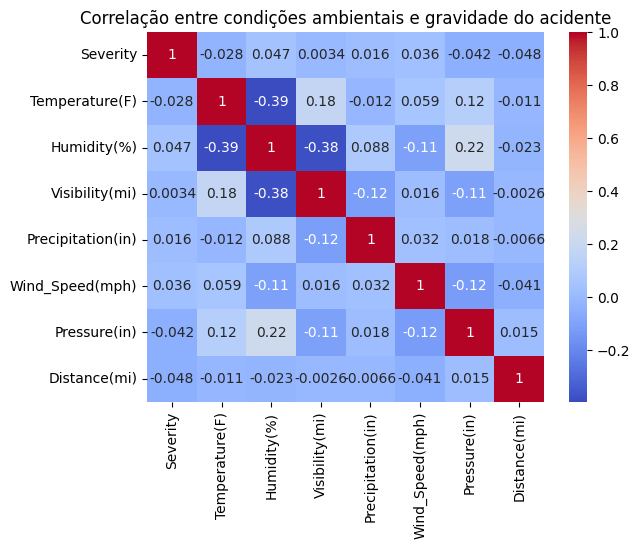

In [18]:
# Selecionar variáveis numéricas relevantes
num_cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
            'Precipitation(in)', 'Wind_Speed(mph)', 'Pressure(in)', 'Distance(mi)']

# Remover linhas com valores ausentes
df_corr = accidents_pollution[num_cols].dropna()

# Calcular correlação
corr_matrix = df_corr.corr()

# Exibir
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlação entre condições ambientais e gravidade do acidente")
plt.show()

### Frequency analysis with categorical variables (e.g. Weather_Condition, Sunrise_Sunset)

In [32]:
# Média da gravidade por condição climática
weather_condition = accidents_pollution.copy()
weather_severity_counts = (
    weather_condition.groupby(['Weather_Condition', 'Severity'])
    .size()
    .reset_index(name='count')
    .sort_values(by=['count', 'Severity', 'Weather_Condition'], ascending=False)
)

weather_severity_counts

,Weather_Condition,Severity,count
35,Fair,2,559328
161,Mostly Cloudy,2,216144
17,Cloudy,2,157705
179,Partly Cloudy,2,143395
13,Clear,2,137806
...,...,...,...
273,Widespread Dust,1,1
260,Thunder and Hail,1,1
194,Rain / Windy,1,1
59,Haze / Windy,1,1


In [33]:
# Gravidade média por condição de iluminação
Sunrise_Sunset = accidents_pollution.copy()
Sunrise_Sunset_counts = (
    Sunrise_Sunset.groupby(['Sunrise_Sunset', 'Severity'])
    .size()
    .reset_index(name='count')
    .sort_values(by=['count', 'Severity', 'Sunrise_Sunset'], ascending=False)
)
Sunrise_Sunset_counts

,Sunrise_Sunset,Severity,count
1,Day,2,1029162
5,Night,2,458893
2,Day,3,233936
6,Night,3,102613
0,Day,1,18213
3,Day,4,12276
7,Night,4,9476
4,Night,1,3920


### Presence of road elements (Boolean variables)

In [36]:
# Comparar gravidade média entre presença e ausência de elementos
road_features = ['Bump', 'Crossing', 'Junction', 'Traffic_Signal', 'Roundabout', 'Stop']
accidents_pollution_group = accidents_pollution.copy()

for feature in road_features:
    means = accidents_pollution_group.groupby(feature)["Severity"].mean()
    print(f"{feature}:\n{means}\n")

Bump:
Bump
False    2.191667
True     2.109425
Name: Severity, dtype: float64

Crossing:
Crossing
False    2.223496
True     2.039690
Name: Severity, dtype: float64

Junction:
Junction
False    2.183782
True     2.277430
Name: Severity, dtype: float64

Traffic_Signal:
Traffic_Signal
False    2.225880
True     2.061908
Name: Severity, dtype: float64

Roundabout:
Roundabout
False    2.191576
True     2.071429
Name: Severity, dtype: float64

Stop:
Stop
False    2.198609
True     2.035112
Name: Severity, dtype: float64



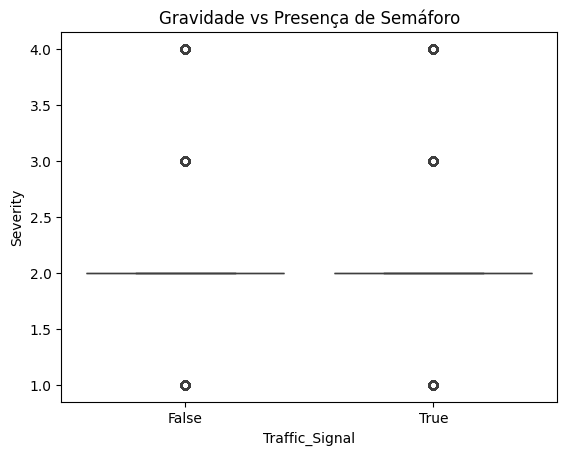

In [37]:
sns.boxplot(data=accidents_pollution, x='Traffic_Signal', y='Severity')
plt.title("Gravidade vs Presença de Semáforo")
plt.show()

Based on this boxplot, there is no strong visual evidence that the presence of traffic lights has a significant influence on the severity of accidents.


The median and dispersion are very similar in the two scenarios.

In [41]:
# dados estatísticos formais (teste t)
road_features = ['Bump', 'Crossing', 'Junction', 'Traffic_Signal', 'Roundabout', 'Stop']
accidents_pollution_group = accidents_pollution.copy()

print("Análise estatística: Severidade x Elementos Viários\n")

for feature in road_features:
    # separa grupos True e False
    group_true = accidents_pollution_group[accidents_pollution_group[feature] == True]["Severity"].dropna()
    group_false = accidents_pollution_group[accidents_pollution_group[feature] == False]["Severity"].dropna()

    # aplica o teste t
    if len(group_true) > 0 and len(group_false) > 0:
        stat, p = ttest_ind(group_true, group_false, equal_var=False)
        print(f"{feature}:")
        print(f"  Média (com {feature}): {group_true.mean():.2f}")
        print(f"  Média (sem {feature}): {group_false.mean():.2f}")
        print(f"  T-statistic = {stat:.3f}, P-value = {p:.4f}")
        print("  → Diferença significativa" if p < 0.05 else "  → Diferença não significativa")
        print("-" * 50)

Análise estatística: Severidade x Elementos Viários

Bump:
  Média (com Bump): 2.11
  Média (sem Bump): 2.19
  T-statistic = -10.915, P-value = 0.0000
  → Diferença significativa
--------------------------------------------------
Crossing:
  Média (com Crossing): 2.04
  Média (sem Crossing): 2.22
  T-statistic = -251.376, P-value = 0.0000
  → Diferença significativa
--------------------------------------------------
Junction:
  Média (com Junction): 2.28
  Média (sem Junction): 2.18
  T-statistic = 70.767, P-value = 0.0000
  → Diferença significativa
--------------------------------------------------
Traffic_Signal:
  Média (com Traffic_Signal): 2.06
  Média (sem Traffic_Signal): 2.23
  T-statistic = -228.795, P-value = 0.0000
  → Diferença significativa
--------------------------------------------------
Roundabout:
  Média (com Roundabout): 2.07
  Média (sem Roundabout): 2.19
  T-statistic = -3.240, P-value = 0.0018
  → Diferença significativa
-----------------------------------------

🧾 Statistical Summary – Impact of Road Features on Accident Severity

We performed independent t-tests to compare the mean accident severity between the presence and absence of various road infrastructure elements. The variable `Severity` ranges from 1 (least severe) to 4 (most severe).

All tested features yielded **p-values < 0.05**, indicating **statistically significant differences** in severity depending on the presence of these features.

---

| Road Feature       | Mean with Feature | Mean without Feature | P-value  | Statistically Significant? | Interpretation                                                                 |
|--------------------|-------------------|------------------------|----------|-----------------------------|--------------------------------------------------------------------------------|
| **Bump**           | 2.11              | 2.19                   | < 0.0001 | Yes                         | Accidents near bumps tend to be slightly **less severe**.                      |
| **Crossing**       | 2.04              | 2.22                   | < 0.0001 | Yes                         | Crosswalks are associated with **lower accident severity**.                    |
| **Junction**       | 2.28              | 2.18                   | < 0.0001 | Yes                         | Accidents at junctions are **more severe on average**.                         |
| **Traffic Signal** | 2.06              | 2.23                   | < 0.0001 | Yes                         | The presence of traffic signals correlates with **lower severity**.            |
| **Roundabout**     | 2.07              | 2.19                   | 0.0018   | Yes                         | Roundabouts are linked to **slightly reduced severity**.                       |
| **Stop**           | 2.04              | 2.20                   | < 0.0001 | Yes                         | Stop signs are associated with **less severe accidents**.                      |

---

✅ Overall Conclusion:

> All examined road features showed a statistically significant impact on accident severity. Notably, **Crossing**, **Stop**, and **Traffic Signal** stand out as associated with **notably lower severity**, reinforcing the importance of traffic control infrastructure for road safety.

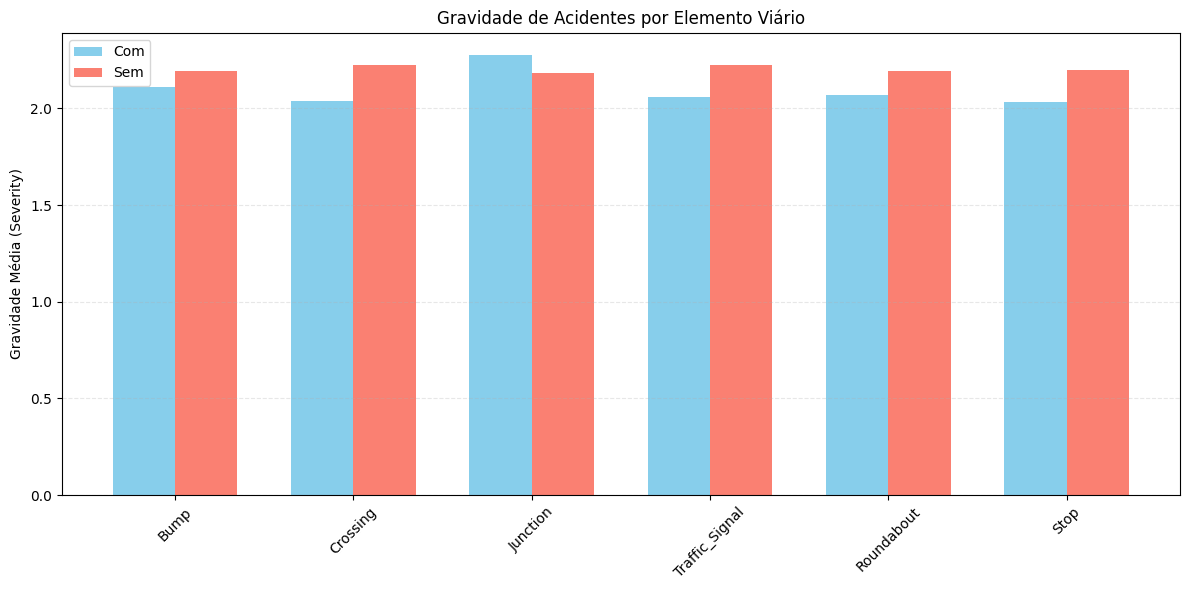

In [45]:
# Função para gerar gráficos
def plot_road_feature_analysis(df, features):
    # Dicionários para armazenar resultados
    means_with = {}
    means_without = {}
    p_values = {}
    
    # Calcula médias e p-values para cada feature
    for feature in features:
        group_true = df[df[feature] == True]["Severity"].dropna()
        group_false = df[df[feature] == False]["Severity"].dropna()
        
        if len(group_true) > 0 and len(group_false) > 0:
            stat, p = ttest_ind(group_true, group_false, equal_var=False)
            means_with[feature] = group_true.mean()
            means_without[feature] = group_false.mean()
            p_values[feature] = p
    
    # --- Gráfico 1: Comparação de Médias ---
    plt.figure(figsize=(12, 6))
    x = np.arange(len(features))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, [means_with[f] for f in features], width, 
                   label='Com', color='skyblue')
    bars2 = plt.bar(x + width/2, [means_without[f] for f in features], width, 
                   label='Sem', color='salmon')
    
    plt.ylabel('Gravidade Média (Severity)')
    plt.title('Gravidade de Acidentes por Elementos da estrada')
    plt.xticks(x, features, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
# Variáveis a analidsar
road_features = ['Bump', 'Crossing', 'Junction', 'Traffic_Signal', 'Roundabout', 'Stop']
accidents_pollution_group = accidents_pollution.copy()

# Executa a análise e plota os gráficos
plot_road_feature_analysis(accidents_pollution_group, road_features)

### Gravity by temperature and humidity

<Axes: >

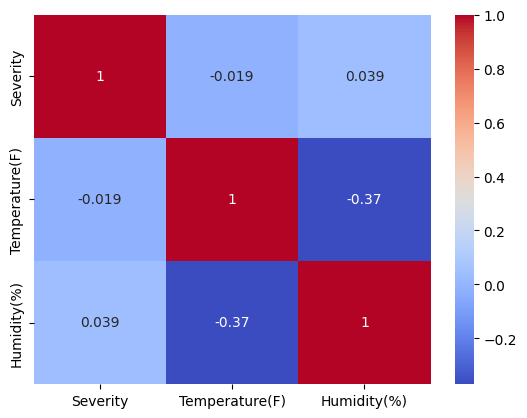

In [46]:
sns.heatmap(
    accidents_pollution[["Severity", "Temperature(F)", "Humidity(%)"]].corr(),
    annot=True, cmap="coolwarm"
)

### Map US

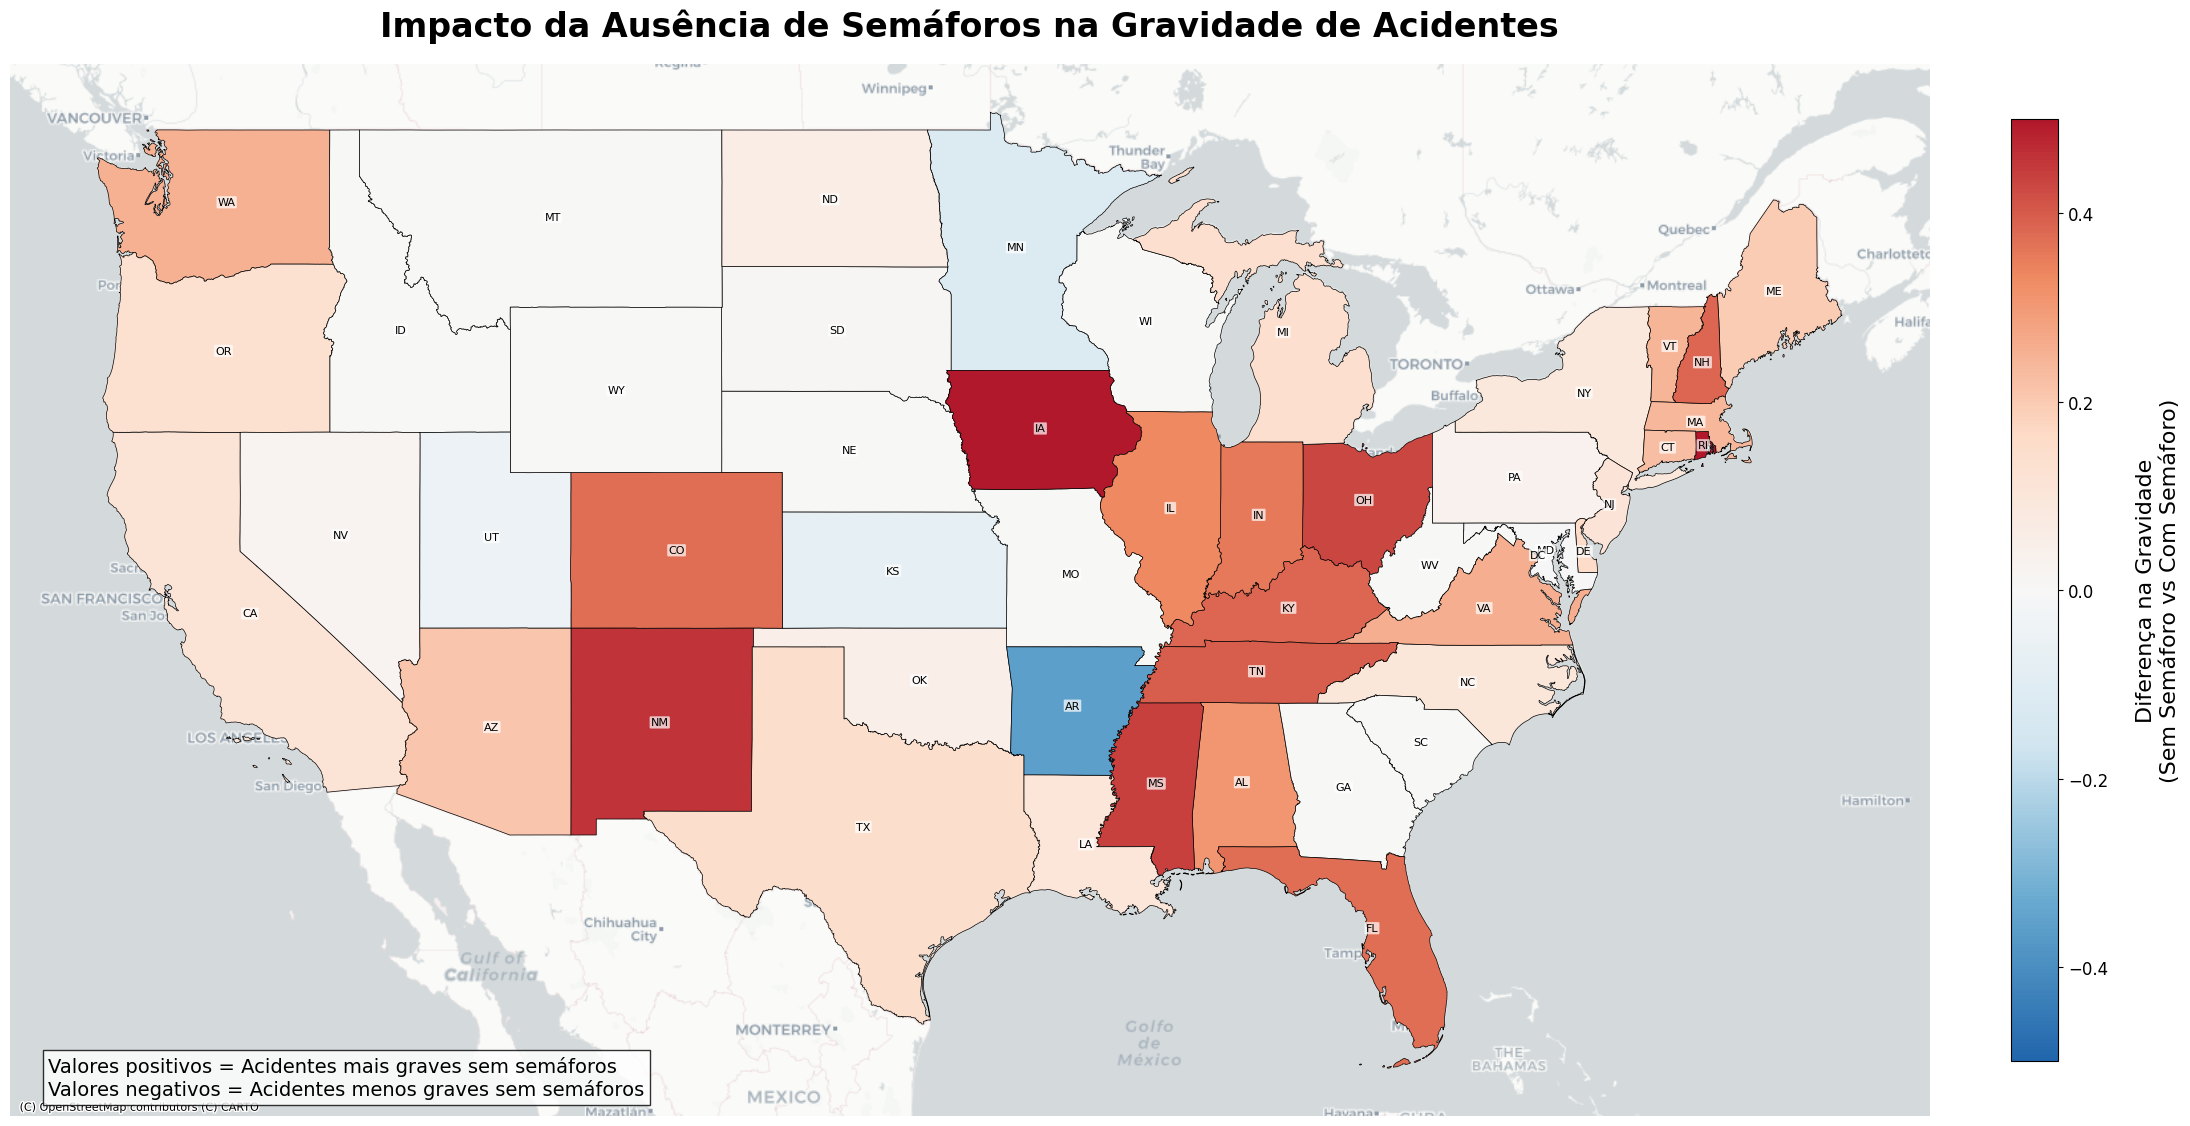

In [12]:
accidents_pollution_map = accidents_pollution.copy()
# 1. Calcular estatísticas por estado
def calculate_state_stats(df):
    stats = []
    for state, group in df.groupby('State'):
        with_signal = group[group['Traffic_Signal'] == True]['Severity']
        without_signal = group[group['Traffic_Signal'] == False]['Severity']
        
        if len(with_signal) > 0 and len(without_signal) > 0:
            diff = without_signal.mean() - with_signal.mean()
            stats.append({'State': state, 'Severity_Difference': diff})
    
    state_stats = pd.DataFrame(stats)
    state_stats['Severity_Difference'] = state_stats['Severity_Difference'].fillna(0)
    state_stats['Severity_Difference'] = np.clip(state_stats['Severity_Difference'], -1, 1)
    
    return state_stats

# 2. Carregar shapefile dos EUA
def load_us_map():
    # Tente carregar shapefile local se existir
    shapefile_path = "cb_2018_us_state_5m.shp"
    if os.path.exists(shapefile_path):
        try:
            us_states = gpd.read_file(shapefile_path)
            non_continental = ['AS', 'GU', 'MP', 'PR', 'VI', 'HI', 'AK']
            us_states = us_states[~us_states['STUSPS'].isin(non_continental)]
            us_states = us_states.to_crs(epsg=3857)
            return us_states
        except:
            pass
    
    # Carregar dados dos EUA usando geodatasets
    try:
        us_states = gpd.read_file(geodatasets.get_path("geoda natregions"))
        us_states = us_states.rename(columns={'STATE_ABBR': 'STUSPS', 'STATE_NAME': 'NAME'})
        non_continental = ['AK', 'HI', 'PR']
        us_states = us_states[~us_states['STUSPS'].isin(non_continental)]
        us_states = us_states.to_crs(epsg=3857)
        return us_states
    except:
        from shapely.geometry import box
        us_bbox = box(-125, 24, -66, 50)
        usa = gpd.GeoDataFrame(geometry=[us_bbox], crs="EPSG:4326")
        usa = usa.to_crs(epsg=3857)
        return usa

# 3. Criar o mapa
def create_impact_map(df):
    # Calcular estatísticas
    state_stats = calculate_state_stats(df)
    
    # Carregar mapa
    us_states = load_us_map()
    
    # Juntar dados ao mapa
    if 'STUSPS' in us_states.columns:
        merged = us_states.merge(state_stats, left_on='STUSPS', right_on='State', how='left')
    else:
        merged = us_states.copy()
        merged['State'] = 'US'
        merged['Severity_Difference'] = 0
        merged = merged.merge(state_stats, on='State', how='left')
    
    merged['Severity_Difference'] = merged['Severity_Difference'].fillna(0)
    
    # Configurar plot
    fig, ax = plt.subplots(figsize=(22, 15))
    
    # Criar gradiente de cores
    colors = ["#2166ac", "#67a9cf", "#d1e5f0", "#f7f7f7", "#fddbc7", "#ef8a62", "#b2182b"]
    cmap = LinearSegmentedColormap.from_list("rd_bu", colors, N=256)
    vmin, vmax = -0.5, 0.5
    
    # Plotar estados - CORREÇÃO PRINCIPAL: especificar ax e adicionar mappable
    mappable = merged.plot(column='Severity_Difference', 
                          cmap=cmap, 
                          ax=ax, 
                          edgecolor='black', 
                          linewidth=0.5,
                          vmin=vmin,
                          vmax=vmax,
                          legend=False,
                          missing_kwds={'color': 'lightgrey'})
    
    # Adicionar mapa de fundo
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=5)
    except:
        pass
    
    # Configurações do mapa
    ax.set_title('Impacto da Ausência de Semáforos na Gravidade de Acidentes', 
                fontsize=24, pad=20, fontweight='bold')
    ax.set_axis_off()
    
    # Adicionar rótulos dos estados
    if 'STUSPS' in merged.columns:
        for idx, row in merged.iterrows():
            try:
                centroid = row['geometry'].centroid
                ax.text(centroid.x, centroid.y, row['STUSPS'], 
                       fontsize=8, ha='center', va='center',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))
            except:
                pass
    
    # Adicionar barra de cores - CORREÇÃO PRINCIPAL: usar mappable e ax
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.023, pad=0.04)  # Especificar ax aqui
    cbar.set_label('Diferença na Gravidade\n(Sem Semáforo vs Com Semáforo)', 
                  fontsize=16, labelpad=20)
    cbar.ax.tick_params(labelsize=12)
    
    # Adicionar legenda
    ax.text(0.02, 0.02, 
           "Valores positivos = Acidentes mais graves sem semáforos\nValores negativos = Acidentes menos graves sem semáforos",
           transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('acidentes_vs_semafaros.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return merged

# 4. Preparar os dados
state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC'
}

if 'State' in accidents_pollution_map.columns:
    accidents_pollution_map['State_Code'] = accidents_pollution_map['State'].map(state_abbr)
    mask = accidents_pollution_map['State_Code'].isna()
    accidents_pollution_map.loc[mask, 'State_Code'] = accidents_pollution_map.loc[mask, 'State']
    accidents_pollution_map = accidents_pollution_map.drop(columns=['State'])
    accidents_pollution_map = accidents_pollution_map.rename(columns={'State_Code': 'State'})

# Criar o mapa
result_map = create_impact_map(accidents_pollution_map)